In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

## Getting normalized Bounding Boxes in COCO Dataset

In [3]:
import os
print(os.getcwd())

/tf/home/sergio/Tesis/TinyYOLOv3-Pedestrian-Detection/Bouding Box Calculation


In [4]:
root_path= "/tf/home/sergio/Tesis"

In [5]:
dataDir=root_path+'/COCODataset'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
print(annFile)
coco=COCO(annFile)

/tf/home/sergio/Tesis/COCODataset/annotations/instances_train2017.json
loading annotations into memory...
Done (t=7.96s)
creating index...
index created!


In [6]:
catIds = coco.getCatIds(catNms=['person']); #ID de la categoría persona
imgIds = coco.getImgIds(catIds=catIds ); # IDS de las imagenes con la categoria persona
annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds) #Anotaciones de las imágenes con la categoría persona
img_metadata = coco.loadImgs(imgIds) # Metadatos de las images de la categoría persona
img_annotations = coco.loadAnns(annIds) # Anotaciones de las instancias de la base de datos

In [7]:
img_annotations[0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [8]:
import os
os.chdir(root_path+"/COCODataset/pedestrian_dataset_train")

In [9]:
def get_normalized_bbox_COCO(image_metadata,instances_annotations,output_size):
    
    info_images = {}

    for i in image_metadata:
        info_images[str(i["id"])]={"width":i["width"],
                              "height":i["height"]}

    bbox_dim = np.zeros((len(instances_annotations),2))

    for index,i in enumerate(instances_annotations):

        key = str(i["image_id"])
        width = info_images[key]["width"]
        height = info_images[key]["height"]
        bbox_dim[index,0] = i["bbox"][2]*(output_size/width)
        bbox_dim[index,1] = i["bbox"][3]*(output_size/height)
        
    return bbox_dim


norm_bbox_array = get_normalized_bbox_COCO(img_metadata,img_annotations,416)

## Getting normalized Bounding Boxes in VOC Dataset

In [10]:
#Reading the metadata and the annotation files
import pandas as pd
import os

os.chdir(root_path+"/VOC2012")
voc_img_annotations = pd.read_csv("VOC_annotations.csv")
voc_img_metadata = pd.read_csv("VOC_metadata.csv",index_col = 0)

In [11]:
voc_img_annotations.head()

,file_name,xmin,ymin,xmax,ymax
0,2011_004953.jpg,0.048048,0.034000,0.903904,1.000
1,2008_006944.jpg,0.384000,0.288000,0.582000,0.832
2,2008_006944.jpg,0.458000,0.240000,0.620000,0.576
3,2011_000700.jpg,0.570455,0.179775,0.872727,1.000
4,2011_000700.jpg,0.263636,0.059925,0.581818,1.000


In [12]:
voc_img_annotations.shape

(17401, 5)

In [13]:
voc_img_metadata.head()

,width,height
2011_004953.jpg,333,500
2008_006944.jpg,500,375
2011_000700.jpg,440,267
2010_006541.jpg,500,375
2011_004154.jpg,500,375


In [14]:
kept_files = []
person_instances =0
total_instances = 0
'''
for i in xml_files:
    file_name, boxes, classes = read_content(i)
    total_instances += len(boxes)
    if "person" in classes:
        kept_files.append(file_name)
        num_person = classes.count("person")
        person_instances +=num_person
'''

def get_normalized_bbox_VOC(ann_df,meta_df,output_size):
    
    bbox_dim = np.zeros((ann_df.shape[0],2))
    
    for index, row in ann_df.iterrows():
        file_name = row["file_name"]
        width = row["xmax"]-row["xmin"]
        height = row["ymax"]-row["ymin"]
        
        img_width = meta_df.loc[file_name]["width"]
        img_height= meta_df.loc[file_name]["height"]
        
        #bbox_dim[index,0] = (width/img_width)*output_size
        #bbox_dim[index,1] = (height/img_height)*output_size

        bbox_dim[index,0] = width
        bbox_dim[index,1] = height
        
        bbox_dim = bbox_dim
    '''
    for i in xml_files_person:
        file_name, boxes, classes = read_content(i)
    
    info_images = {}

    for i in image_metadata:
        info_images[str(i["id"])]={"width":i["width"],
                              "height":i["height"]}

    bbox_dim = np.zeros((len(instances_annotations),2))

    for index,i in enumerate(instances_annotations):

        key = str(i["image_id"])
        width = info_images[key]["width"]
        height = info_images[key]["height"]
        bbox_dim[index,0] = i["bbox"][2]*(output_size/width)
        bbox_dim[index,1] = i["bbox"][3]*(output_size/height)
    ''' 
    return bbox_dim

norm_bbox_array_voc = get_normalized_bbox_VOC(voc_img_annotations,voc_img_metadata,1)
norm_bbox_array_coco = get_normalized_bbox_COCO(img_metadata,img_annotations,1)
bbox_array_dataset = np.concatenate((norm_bbox_array_coco,norm_bbox_array_voc),axis=0)
bbox_array_dataset.dtype

dtype('float64')

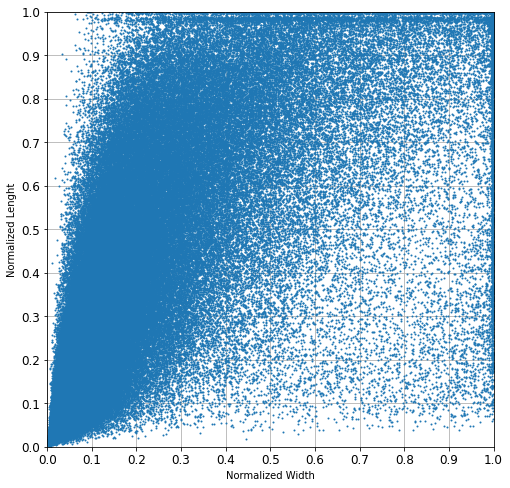

In [15]:
#plt.plot(norm_bbox_array_coco[:,0],norm_bbox_array_coco[:,1],'o',markersize=1)
#plt.plot(norm_bbox_array_voc[:,0],norm_bbox_array_voc[:,1],'go',markersize=1)
plt.plot(bbox_array_dataset[:,0],bbox_array_dataset[:,1],'o',markersize=1)
plt.xlabel("Normalized Width")
plt.ylabel("Normalized Lenght")
plt.xticks(np.arange(0,1.1,0.1),fontsize=12)
plt.yticks(np.arange(0,1.1,0.1),fontsize=12)
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()

plt.savefig("dataset_to_cluster",dpi=400)

In [16]:
def IoU (anchor_boxes,x_data):

    samples,dim = x_data.shape
    num_clusters,_,_ = anchor_boxes.shape
    
    cluster_area = np.tile(anchor_boxes[:,0]*anchor_boxes[:,1],samples).T
    box_area = np.repeat((x_data[:,0]*x_data[:,1]).reshape((-1,1)),num_clusters,axis=1)
    anchors_prueba_n = np.tile(anchor_boxes, (samples))
    intersection = np.zeros((samples,num_clusters))
    
    for i in np.arange(num_clusters):
        x = np.minimum(anchors_prueba_n[i, 0,:], x_data[:,0]) 
        y = np.minimum(anchors_prueba_n[i, 1,:], x_data[:,1])
        intersection[:,i] =np.multiply(x,y)

    iou_ = np.divide(intersection , cluster_area+box_area - intersection)
    
    return iou_


anchor_bbox = np.array([[0.2,0.2],[0.5,0.5]])[:,:,np.newaxis]
prueba = np.array([[0.2,0.4],[0.5,1]])


iou = IoU (anchor_bbox,prueba)
print(iou)


[[0.5  0.32]
 [0.08 0.5 ]]


In [17]:
anchor_boxes_6=np.array([[[0.56321678],[0.78614063]]

 ,[[0.02078125],[0.04934375]]

 ,[[0.08522917]
  ,[0.19356   ]]

 ,[[0.27835188]
  ,[0.58651054]]

 ,[[0.15059375]
  ,[0.41628842]]

 ,[[0.04259375]
  ,[0.12871194]]])

In [18]:
anchor_boxes_6.shape

(6, 2, 1)

In [19]:
iou_total = IoU(anchor_boxes_6,bbox_array_dataset)

In [20]:
which_anchor = np.argmax(iou_total,axis=1)
print(which_anchor.shape)

(279866,)


In [21]:
#which_anchor_value=np.zeros(279866,2)
which_anchor_value = anchor_boxes_6[which_anchor,:][:,:,0]

In [22]:
which_anchor_value.shape

(279866, 2)

In [23]:
tw = np.log(np.divide(bbox_array_dataset[:,0]+1e-07,which_anchor_value[:,0]))
th = np.log(np.divide(bbox_array_dataset[:,1]+1e-07,which_anchor_value[:,1]))

In [24]:
tw_alt = np.divide(bbox_array_dataset[:,0]+1e-07,which_anchor_value[:,0])
th_alt = np.divide(bbox_array_dataset[:,1]+1e-07,which_anchor_value[:,1])

In [25]:
iou_total.shape

(279866, 6)

In [56]:
from scipy.stats import skew

Width Skeweness: -0.44633285577237664
Height Skeweness: -1.0837383207188058


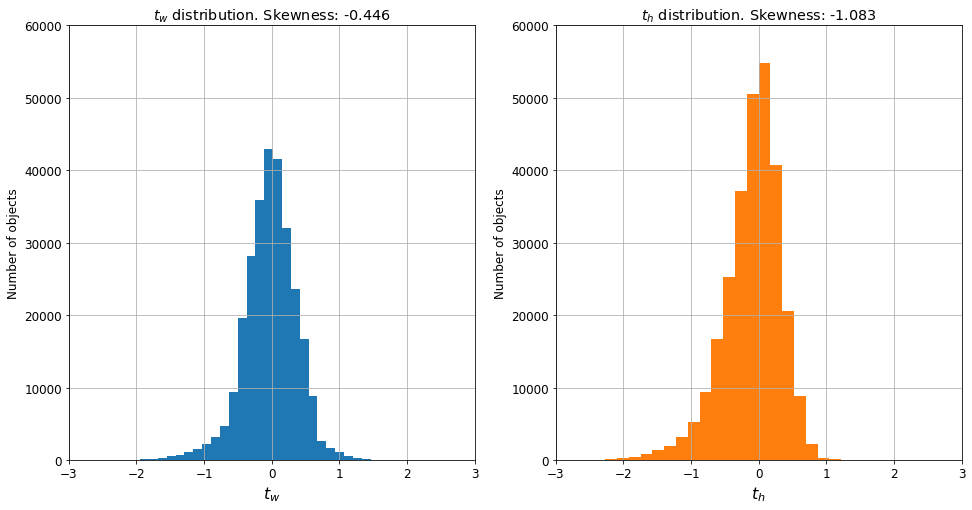

In [86]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 12})

skewness_tw = skew(tw)
skewness_th = skew(th)

#plt.fontisze(12)
plt.subplot(121)
plt.hist(tw,bins=50)
plt.title("$t_w$ distribution. Skewness: "+str(skewness_tw)[:6])
plt.xlabel("$t_w$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([-3,3])
plt.ylim([0,60000])

plt.grid()

plt.subplot(122)
plt.hist(th,bins=100,color="tab:orange")
plt.title("$t_h$ distribution. Skewness: "+str(skewness_th)[:6])
plt.xlabel("$t_h$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([-3,3])
plt.ylim([0,60000])
plt.grid()

plt.savefig("dataset_distribution_ts.png",dpi=400,bbox_inches = 'tight')

print("Width Skeweness:",skew(tw))
print("Height Skeweness:",skew(th))

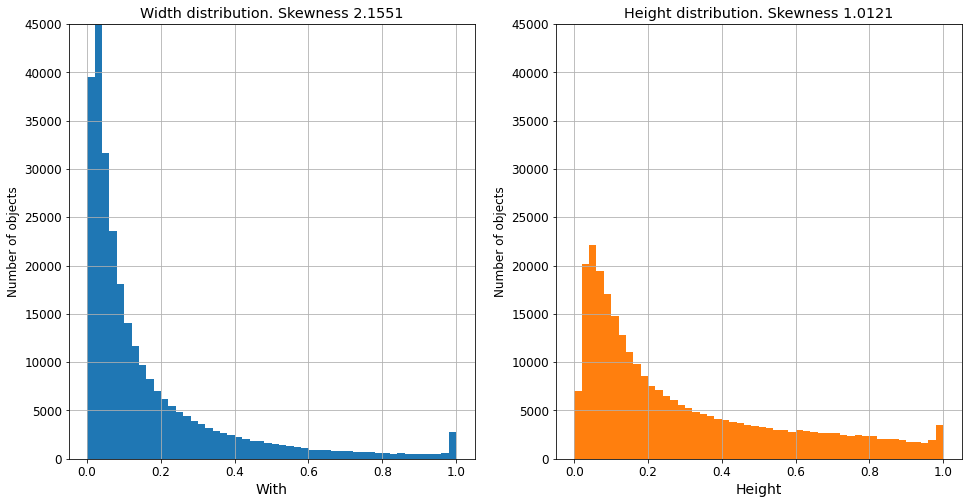

In [87]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 12})

skewness_width = skew(bbox_array_dataset[:,0])
skewness_height = skew(bbox_array_dataset[:,1])

plt.subplot(121)
plt.hist(bbox_array_dataset[:,0],bins=50)
plt.title("Width distribution. Skewness "+str(skewness_width)[:6])
plt.xlabel("With",fontsize=14)
plt.ylabel("Number of objects")
plt.ylim([0,45000])
plt.grid()

plt.subplot(122)
plt.hist(bbox_array_dataset[:,1],bins=50,color="tab:orange")
plt.title("Height distribution. Skewness "+str(skewness_height)[:6])
plt.xlabel("Height",fontsize=14)
plt.ylabel("Number of objects")
plt.ylim([0,45000])
#plt.xlim([-10,10])
plt.grid()

plt.savefig("dataset_distribution.png",dpi=400,bbox_inches = 'tight')

#print(bbox_array_dataset[:,0].shape)
#print("Width Skeweness:",skew(bbox_array_dataset[:,0],bias=False))
#print("Height Skeweness:",skew(bbox_array_dataset[:,1]))

Width Skeweness: 2.450624223245832
Height Skeweness: 0.6013183157180525


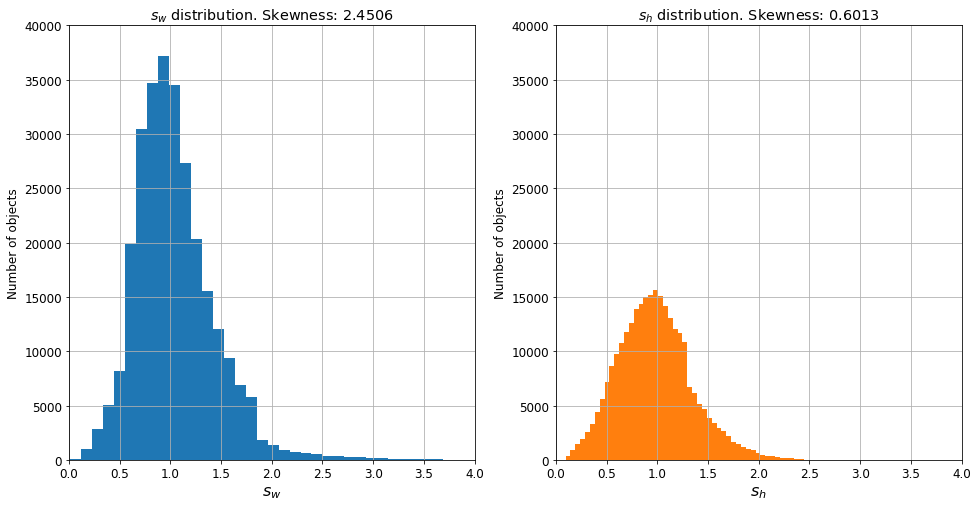

In [88]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 12})

skewness_sw = skew(tw_alt)
skewness_sh = skew(th_alt)
plt.subplot(121)
plt.hist((tw_alt),bins=100)
plt.title("$s_w$ distribution. Skewness: "+str(skewness_sw)[:6])
plt.xlabel("$s_w$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([0,4])
plt.ylim([0,40000])
plt.grid()

plt.subplot(122)
plt.hist((th_alt),bins=100,color="tab:orange")
plt.title("$s_h$ distribution. Skewness: "+str(skewness_sh)[:6])
plt.xlabel("$s_h$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([0,4])
plt.ylim([0,40000])
plt.grid()

plt.savefig("dataset_distribution_ss.png",dpi=400,bbox_inches = 'tight')

print("Width Skeweness:",skew(tw_alt,bias=True))
print("Height Skeweness:",skew(th_alt,bias=True))

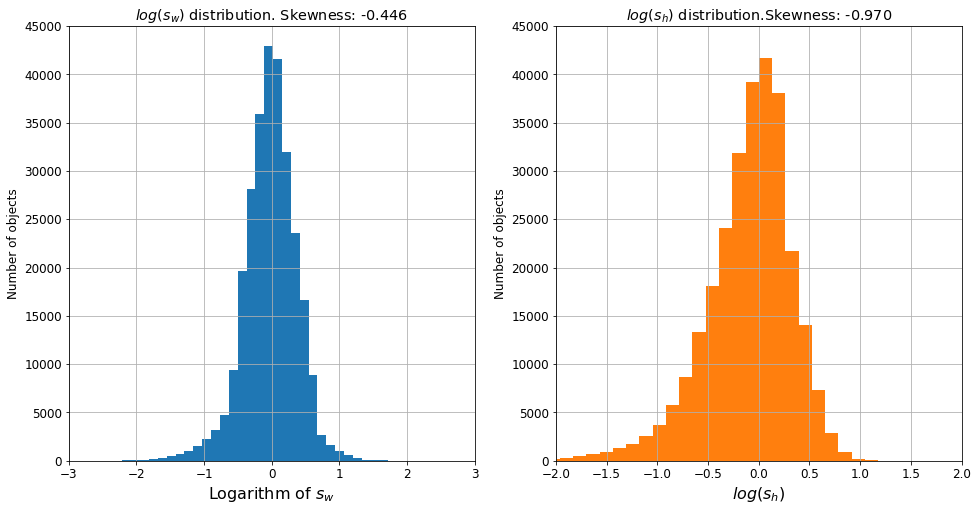

In [89]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 12})

skewness_log_sw = skew(np.log(tw_alt+1e-5))
skewness_log_sh = skew(np.log(th_alt+1e-5))

plt.subplot(121)
plt.hist(np.log(tw_alt+1e-5),bins=50)
plt.title("$log(s_w)$ distribution. Skewness: "+str(skewness_log_sw)[:6])
plt.xlabel("Logarithm of $s_w$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([-3,3])
plt.ylim([0,45000])
plt.grid()

plt.subplot(122)
plt.hist(np.log(th_alt+1e-5),bins=100,color="tab:orange")
plt.title("$log(s_h)$ distribution.Skewness: "+str(skewness_log_sh)[:6])
plt.xlabel("$log(s_h)$",fontsize=16)
plt.ylabel("Number of objects")
plt.xlim([-2,2])
plt.ylim([0,45000])
plt.grid()

plt.savefig("dataset_distribution_log.png",dpi=400,bbox_inches = 'tight')

#print("Width Skeweness:",skew(np.log(tw_alt+1e-5)))
#print("Height Skeweness:",skew(np.log(th_alt+1e-5)))

In [37]:
import os
os.getcwd()

'/tf/home/sergio/Tesis/VOC2012'

## Getting Anchor Boxes

In [13]:
#def IoU(boxes,anchor_boxes):
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [14]:
anchors_prueba = np.array([[120,400],[260,50],[300,120]]).reshape(3,2,1)/416.
print(anchors_prueba.dtype)
print(anchors_prueba.shape)

float64
(3, 2, 1)


In [15]:
def IoU (anchor_boxes,x_data):

    samples,dim = x_data.shape
    num_clusters,_,_ = anchor_boxes.shape
    
    cluster_area = np.tile(anchor_boxes[:,0]*anchor_boxes[:,1],samples).T
    box_area = np.repeat((x_data[:,0]*x_data[:,1]).reshape((-1,1)),num_clusters,axis=1)
    anchors_prueba_n = np.tile(anchor_boxes, (samples))
    intersection = np.zeros((samples,num_clusters))
    
    for i in np.arange(num_clusters):
        x = np.minimum(anchors_prueba_n[i, 0,:], x_data[:,0]) 
        y = np.minimum(anchors_prueba_n[i, 1,:], x_data[:,1])
        intersection[:,i] =np.multiply(x,y)

    iou_ = np.divide(intersection , cluster_area+box_area - intersection)
    
    return iou_


anchor_bbox = np.array([[0.2,0.2],[0.5,0.5]])[:,:,np.newaxis]
prueba = np.array([[0.2,0.4],[0.5,1]])


iou = IoU (anchor_bbox,prueba)
print(iou)


[[0.5  0.32]
 [0.08 0.5 ]]


In [16]:
#%timeit IoU (anchor_bbox,bbox_array_dataset)

In [23]:
#seed para k=4 es 676
#seed para k=6 es 952

def k_means(data,num_clusters,random_seed = 952, normalized = False):
    
    np.random.seed(random_seed)
    centroids = data[np.random.choice(data.shape[0],num_clusters, replace = False),:][:,:,np.newaxis]
    if normalized:
        data=data*1000
        centroids = centroids*1000
    
    i=0
    prev_centroids = np.zeros((num_clusters,2,1))
    while(True):
        iou_ =1- IoU(centroids,data)
        aux = np.argmin(iou_,axis=1)
        
        for j in range(num_clusters):
            centroids[j,:,0]= np.median(data[aux==j,:],axis=0)
        i+=1
        if (np.sum(prev_centroids-centroids)==0)  or (i>1000):
            final_mean_iou = np.median(np.max(IoU(centroids,data),axis=1))
            iou_ =1- IoU(centroids,data)
            aux = np.argmin(iou_,axis=1)
            break
        prev_centroids = centroids
            
    return centroids,final_mean_iou,i,aux


num_clusters = 16
clusters_coco = {}
clusters_voc = {}
clusters_dataset = {}

avg_iou_coco=[]
avg_iou_voc = []
avg_iou_dataset = []

belonged_class_coco = {}
belonged_class_voc = {}
belonged_class_dataset = {}

for i in np.arange(1,num_clusters,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_coco,i)
    avg_iou_coco.append(results)
    clusters_coco[str(i)]=clusters
    belonged_class_coco[str(i)]=belonged_class
    #print(results,epochs)
#print("-------------------------------------------------------")
    
for i in np.arange(1,num_clusters,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_voc,i)
    avg_iou_voc.append(results)
    clusters_voc[str(i)]=clusters
    belonged_class_voc[str(i)]=belonged_class
    #print(results,epochs)   
#print("-------------------------------------------------------")

for i in np.arange(1,num_clusters,1):
    clusters,results,epochs, belonged_class = k_means(bbox_array_dataset,i)
    avg_iou_dataset.append(results)
    clusters_dataset[str(i)]=clusters
    belonged_class_dataset[str(i)]=belonged_class
    #print(results,epochs)

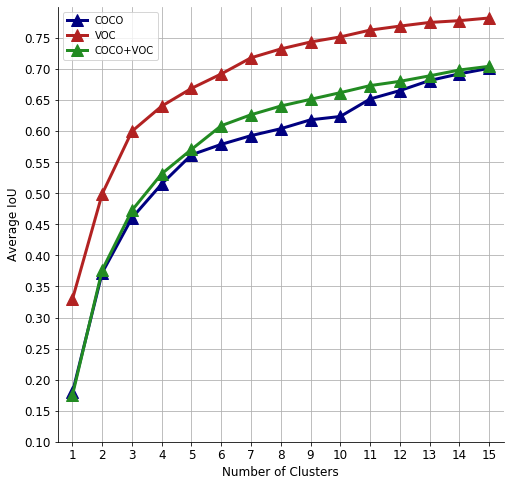

In [24]:
fig, ax0 = plt.subplots(nrows=1)
x = np.arange(1,16,1)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks(np.arange(1,16,1),fontsize=12)
plt.yticks(np.arange(0.1,0.8,0.05),fontsize=12)
ax0.plot(x,avg_iou_coco,"^-", label = "COCO", linewidth=3, markersize=12,color="navy")
ax0.plot(x,avg_iou_voc,"^-",label = "VOC", linewidth=3, markersize=12,color = "firebrick")
ax0.plot(x,avg_iou_dataset,"^-",label = "COCO+VOC",linewidth=3, markersize=12,color="forestgreen")
plt.xlim([0.5,15.5])
plt.ylim([0.1,0.8])
plt.xlabel("Number of Clusters",fontsize=12)
plt.ylabel("Average IoU", fontsize = 12)
plt.grid()
plt.legend()
fig.savefig("diff_num_cluster_diff_datasets_best_random_seed",dpi=400)

[[[0.56321678]
  [0.78614063]]

 [[0.02078125]
  [0.04934375]]

 [[0.08522917]
  [0.19356   ]]

 [[0.27835188]
  [0.58651054]]

 [[0.15059375]
  [0.41628842]]

 [[0.04259375]
  [0.12871194]]]


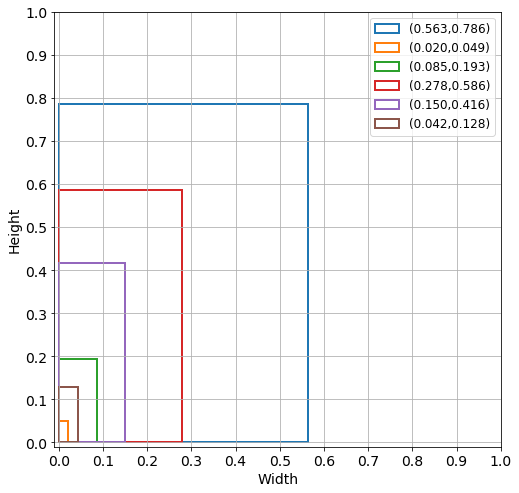

In [27]:
import matplotlib

fig,ax = plt.subplots(1)
fontsize = 14
num_clusters = 6
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray"]
for i in range(num_clusters):
    label = "(" + str(clusters_dataset[str(num_clusters)][i][0][0])[:5] +"," +str(clusters_dataset[str(num_clusters)][i][1][0])[:5] + ")"
    rect=matplotlib.patches.Rectangle((0.0,0.0),clusters_dataset[str(num_clusters)][i][0][0],clusters_dataset[str(num_clusters)][i][1][0],linewidth=2,edgecolor=colors[i],facecolor='none',label = label)
    ax.add_patch(rect)
plt.xlim([-0.01,1])
plt.ylim([-0.01,1])
plt.xlabel("Width",fontsize = fontsize)
plt.ylabel("Height",fontsize = fontsize)
plt.xticks(np.arange(0,1.1,0.1),fontsize=fontsize)
plt.yticks(np.arange(0,1.1,0.1),fontsize=fontsize)
plt.grid()
plt.legend(prop={'size': 12})
plt.savefig("best_anchor_boxes",dpi=400)

print(clusters_dataset[str(num_clusters)])

(31196,)
(63317,)
(52074,)
(36729,)
(42887,)
(53663,)


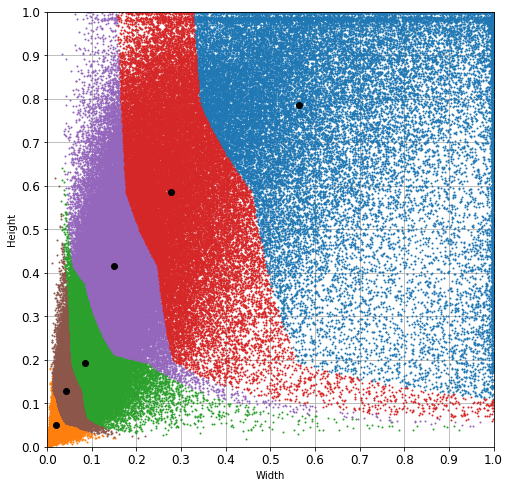

In [26]:
num_clusters = 6
array = belonged_class_dataset[str(num_clusters)]

plt.figure()
plt.xticks(np.arange(0,1.1,0.1),fontsize=12)
plt.yticks(np.arange(0,1.1,0.1),fontsize=12)
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.xlabel("Width")
plt.ylabel("Height")
for j in range(num_clusters):
    partial_array = np.where(array==j)
    print(partial_array[0].shape)
    plt.plot(bbox_array_dataset[partial_array[0],0],bbox_array_dataset[partial_array[0],1],'o',markersize=1)
    plt.plot(clusters_dataset[str(num_clusters)][j][0][0],clusters_dataset[str(num_clusters)][j][1][0],'o',color = 'k')
plt.savefig("clustered_dataset",dpi=400)

## BEST centroids with k=4

In [189]:
number_random_seed = 1000
clusters_coco = {}
clusters_voc = {}
clusters_dataset = {}

avg_iou_coco=[]
avg_iou_voc = []
avg_iou_dataset = []

belonged_class_coco = {}
belonged_class_voc = {}
belonged_class_dataset = {}

print("1000 experimentos con centroides de COCO")
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_coco,4,random_seed=i)
    avg_iou_coco.append(results)
    clusters_coco[str(i)]=clusters
    belonged_class_coco[str(i)]=belonged_class
    #print(results,epochs)

print("1000 experimentos con centroides de VOC") 
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_voc,4,random_seed=i)
    avg_iou_voc.append(results)
    clusters_voc[str(i)]=clusters
    belonged_class_voc[str(i)]=belonged_class
    #print(results,epochs)   
#print("-------------------------------------------------------")

print("1000 experimentos con centroides de Dataset") 
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs, belonged_class = k_means(bbox_array_dataset,4,random_seed=i)
    avg_iou_dataset.append(results)
    clusters_dataset[str(i)]=clusters
    belonged_class_dataset[str(i)]=belonged_class
    #print(results,epochs)

    
print(np.argmax(avg_iou_dataset))
print(np.max(avg_iou_dataset))

1000 experimentos con centroides de COCO
1000 experimentos con centroides de VOC
1000 experimentos con centroides de Dataset
676
0.544262516440561


In [172]:
real_result = []
for i in np.arange(0,10,1):
    real_result.append(np.sum(np.array(avg_iou_dataset[1000*i:(i+1)*1000])>0.5)/1000)

In [173]:
real_result

[0.0, 0.0, 0.886, 0.993, 0.999, 1.0, 1.0, 1.0, 1.0, 0.0]

## BEST centroids with k=6

In [20]:
number_random_seed = 1000
clusters_coco = {}
clusters_voc = {}
clusters_dataset = {}

avg_iou_coco=[]
avg_iou_voc = []
avg_iou_dataset = []

belonged_class_coco = {}
belonged_class_voc = {}
belonged_class_dataset = {}

num_clusters = 6

print("1000 experimentos con centroides de COCO")
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_coco,num_clusters,random_seed=i)
    avg_iou_coco.append(results)
    clusters_coco[str(i)]=clusters
    belonged_class_coco[str(i)]=belonged_class
    #print(results,epochs)

print("1000 experimentos con centroides de VOC") 
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs,belonged_class = k_means(norm_bbox_array_voc,num_clusters,random_seed=i)
    avg_iou_voc.append(results)
    clusters_voc[str(i)]=clusters
    belonged_class_voc[str(i)]=belonged_class
    #print(results,epochs)   
#print("-------------------------------------------------------")

print("1000 experimentos con centroides de Dataset") 
for i in np.arange(0,number_random_seed,1):
    clusters,results,epochs, belonged_class = k_means(bbox_array_dataset,num_clusters,random_seed=i)
    avg_iou_dataset.append(results)
    clusters_dataset[str(i)]=clusters
    belonged_class_dataset[str(i)]=belonged_class
    #print(results,epochs)

    
print(np.argmax(avg_iou_dataset))
print(np.max(avg_iou_dataset))

1000 experimentos con centroides de COCO
1000 experimentos con centroides de VOC
1000 experimentos con centroides de Dataset
952
0.6088061888973904


In [21]:
real_result = []
for i in np.arange(0,10,1):
    real_result.append(np.sum(np.array(avg_iou_dataset[1000*i:(i+1)*1000])>0.5)/1000)

In [22]:
real_result

[0.999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Kmeans with Euclidean DIstance

In [35]:
from sklearn.cluster import KMeans

num_clusters = 16

clusters_dataset_sk = {}
avg_iou_dataset_sk = []
belonged_class_dataset_sk = {}


for i in np.arange(1,num_clusters,1):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=419).fit(bbox_array_dataset)
    found_bbox=kmeans.cluster_centers_[:,:,np.newaxis]
    clusters_dataset_sk[str(i)]=found_bbox
    final_mean_iou = np.median(np.max(IoU(found_bbox,bbox_array_dataset),axis=1))
    avg_iou_dataset_sk.append(final_mean_iou)
    belonged_class_dataset_sk[str(i)]=kmeans.labels_

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [30]:
from sklearn.cluster import KMeans

num_random_seed = 1000

clusters_dataset_sk = {}
avg_iou_dataset_sk = []
belonged_class_dataset_sk = {}


for i in np.arange(1,num_random_seed,1):
    print(i)
    kmeans = KMeans(n_clusters=4, random_state=i).fit(bbox_array_dataset)
    found_bbox=kmeans.cluster_centers_[:,:,np.newaxis]
    clusters_dataset_sk[str(i)]=found_bbox
    final_mean_iou = np.median(np.max(IoU(found_bbox,bbox_array_dataset),axis=1))
    avg_iou_dataset_sk.append(final_mean_iou)
    belonged_class_dataset_sk[str(i)]=kmeans.labels_

KeyboardInterrupt: 

In [45]:
print(avg_iou_dataset_sk[3])
print(avg_iou_dataset_sk[3])

0.5012071106150224
0.5012071106150224


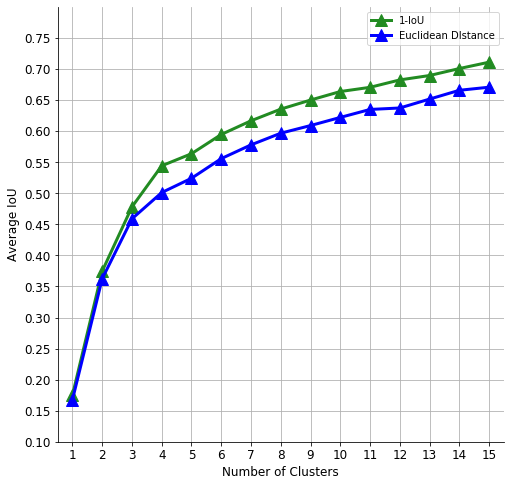

In [37]:
fig, ax0 = plt.subplots(nrows=1)
x = np.arange(1,16,1)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks(np.arange(1,16,1),fontsize=12)
plt.yticks(np.arange(0.1,0.8,0.05),fontsize=12)
#ax0.plot(x,avg_iou_coco,"^-", label = "COCO", linewidth=3, markersize=12,color="navy")
#ax0.plot(x,avg_iou_voc,"^-",label = "VOC", linewidth=3, markersize=12,color = "firebrick")
ax0.plot(x,avg_iou_dataset,"^-",label = "1-IoU",linewidth=3, markersize=12,color="forestgreen")
ax0.plot(x,avg_iou_dataset_sk,"^-",label = "Euclidean DIstance",linewidth=3, markersize=12,color="blue")
plt.xlim([0.5,15.5])
plt.ylim([0.1,0.8])
plt.xlabel("Number of Clusters",fontsize=12)
plt.ylabel("Average IoU", fontsize = 12)
plt.grid()
plt.legend()
plt.savefig("best_euclidean_vs_iou",dpi=400)

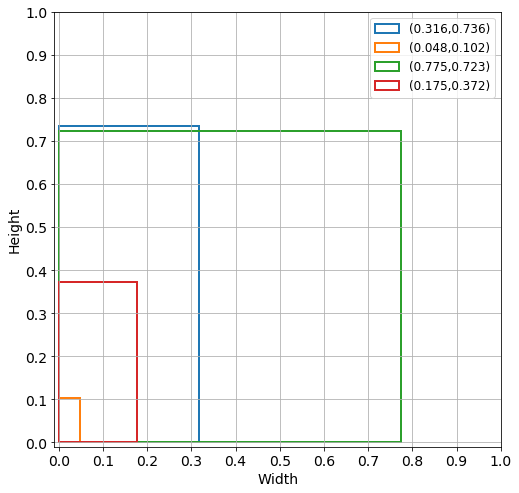

In [40]:
import matplotlib

fig,ax = plt.subplots(1)
fontsize = 14
num_clusters = 4
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray"]
for i in range(num_clusters):
    label = "(" + str(clusters_dataset_sk[str(num_clusters)][i][0][0])[:5] +"," +str(clusters_dataset_sk[str(num_clusters)][i][1][0])[:5] + ")"
    rect=matplotlib.patches.Rectangle((0.0,0.0),clusters_dataset_sk[str(num_clusters)][i][0][0],clusters_dataset_sk[str(num_clusters)][i][1][0],linewidth=2,edgecolor=colors[i],facecolor='none',label = label)
    ax.add_patch(rect)
plt.xlim([-0.01,1])
plt.ylim([-0.01,1])
plt.xlabel("Width",fontsize = fontsize)
plt.ylabel("Height",fontsize = fontsize)
plt.xticks(np.arange(0,1.1,0.1),fontsize=fontsize)
plt.yticks(np.arange(0,1.1,0.1),fontsize=fontsize)
plt.grid()
plt.legend(prop={'size': 12})
plt.savefig("best_anchors_boxes_euclidean",dpi=400)

(39996,)
(155134,)
(17908,)
(66828,)


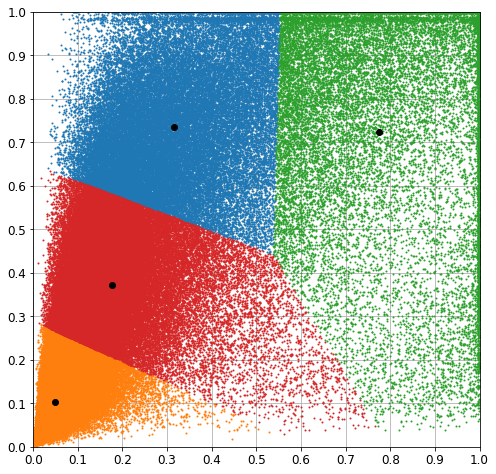

In [39]:
num_clusters = 4
array = belonged_class_dataset_sk[str(num_clusters)]

plt.figure()
plt.xticks(np.arange(0,1.1,0.1),fontsize=12)
plt.yticks(np.arange(0,1.1,0.1),fontsize=12)
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
for j in range(num_clusters):
    partial_array = np.where(array==j)
    print(partial_array[0].shape)
    plt.plot(bbox_array_dataset[partial_array[0],0],bbox_array_dataset[partial_array[0],1],'o',markersize=1)
    plt.plot(clusters_dataset_sk[str(num_clusters)][j][0][0],clusters_dataset_sk[str(num_clusters)][j][1][0],'o',color = 'k')
plt.savefig("clustered_dataset_euclidean",dpi=400)

In [24]:
kmeans.cluster_centers_.shape

(15, 2)

In [25]:
norm_bbox_array_coco[np.random.choice(norm_bbox_array_coco.shape[0],3, replace = False),:]


array([[0.02453125, 0.08397917],
       [0.02620313, 0.07283333],
       [0.04078125, 0.1198829 ]])

In [26]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [ ]:
rescue_code(k_means)

In [ ]:
def k_means(data,num_clusters,random_seed = 10, normalized = False):
    
    np.random.seed(random_seed)
    centroids = data[np.random.choice(data.shape[0],num_clusters, replace = False),:][:,:,np.newaxis]
    if normalized:
        data=data*1000
        centroids = centroids*1000
    
    i=0
    prev_centroids = np.zeros((num_clusters,2,1))
    while(True):
        iou_ =1- IoU(centroids,data)
        aux = np.argmin(iou_,axis=1)
        
        for j in range(num_clusters):
            centroids[j,:,0]= np.median(data[aux==j,:],axis=0)
        i+=1
        if (np.sum(prev_centroids-centroids)==0)  or (i>1000):
            final_mean_iou = np.median(np.max(IoU(centroids,data),axis=1))
            iou_ =1- IoU(centroids,data)
            aux = np.argmin(iou_,axis=1)
            break
        prev_centroids = centroids
            
    return centroids,final_mean_iou,i,aux


In [ ]:
def k_means(data,num_clusters,random_seed = 1, normalized = False):
    
    np.random.seed(0)
    centroids = data[np.random.choice(data.shape[0],num_clusters, replace = False),:][:,:,np.newaxis]
    if normalized:
        data=data*1000
        centroids = centroids*1000
    
    
    i=0
    prev_centroids = np.zeros((num_clusters,2,1))
    while(True):
        iou_ =1- IoU(centroids,data)
        aux = np.argmin(iou_,axis=1)
        
        for j in range(num_clusters):
            centroids[j,:,0]= np.mean(data[aux==j,:],axis=0)
        i+=1
        if (np.sum(prev_centroids-centroids)==0)  or (i>1000):
            final_mean_iou = np.mean(np.max(IoU(centroids,data),axis=1))
            break
        prev_centroids = centroids
            
    return centroids,final_mean_iou,i,aux
